In [1]:
from importlib import reload
from copy import deepcopy
import os
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision.transforms import ToTensor, RandomCrop, Compose
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.transforms.functional as TF

if not os.path.isdir("./cache"): os.mkdir("cache")
if not os.path.isdir("./data"): os.mkdir("data")

from utils_lib.consts import device, EX2_data_path
print(f'device: {device}')
from utils_lib import utils

device: cuda:2


In [2]:
utils.get_EX2_data()

./data/EX2_data True


## Net 12

In [ ]:
utils.mData12.init()

Prepare 12Net data


>>> Epoch 0, train: loss 0.7096 acc 0.4954, test: loss 0.6988 acc 0.5012, 
>>> Epoch 100, train: loss 0.1770 acc 0.9305, test: loss 0.1844 acc 0.9270, 
>>> Epoch 200, train: loss 0.1409 acc 0.9439, test: loss 0.1544 acc 0.9399, 
>>> Epoch 300, train: loss 0.1234 acc 0.9520, test: loss 0.1414 acc 0.9450, 
>>> Epoch 400, train: loss 0.1131 acc 0.9576, test: loss 0.1347 acc 0.9485, 
>>> Epoch 500, train: loss 0.1042 acc 0.9613, test: loss 0.1314 acc 0.9503, 
>>> Epoch 600, train: loss 0.0976 acc 0.9636, test: loss 0.1279 acc 0.9517, 
>>> Epoch 700, train: loss 0.0926 acc 0.9656, test: loss 0.1248 acc 0.9529, 
>>> Epoch 800, train: loss 0.0879 acc 0.9670, test: loss 0.1229 acc 0.9541, 
>>> Epoch 900, train: loss 0.0844 acc 0.9678, test: loss 0.1277 acc 0.9525, 
>>> Epoch 1000, train: loss 0.0808 acc 0.9703, test: loss 0.1213 acc 0.9560, 
>>> Epoch 1100, train: loss 0.0776 acc 0.9716, test: loss 0.1222 acc 0.9544, 
>>> Epoch 1200, train: loss 0.0747 acc 0.9725, test: loss 0.1180 acc 0.9573,

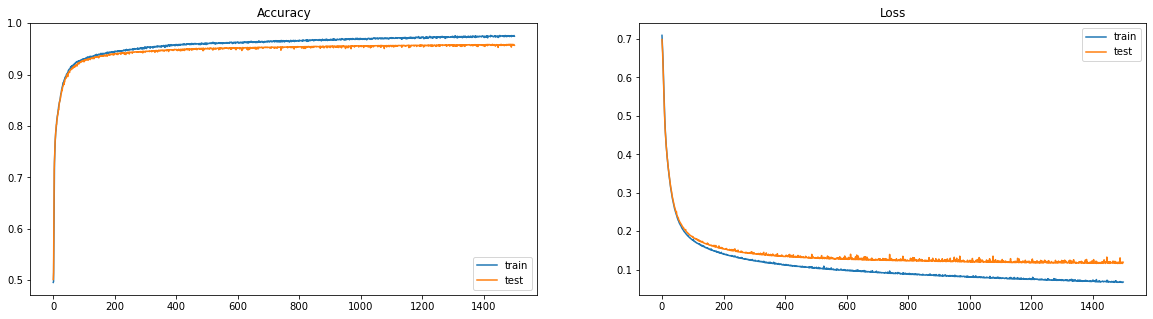

In [3]:
Net12 = nn.Sequential(
    # 3 X 12 X 12
    nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
    # 16 X 12 X 12
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 16 X 6 X 6
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 6 *6, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)
utils.train_12Net(Net12, Epochs = 1500, save = True)

### Simple Detector

Modify the 12 Net into FCN:

In [2]:
Net12 = torch.load("cache/models.12Net.best_model")

In [3]:
Net12_layers = list(Net12._modules.values())
#
conv_layer1 = nn.Conv2d(16, 16, kernel_size = 6, stride = 1)
conv_layer1.weight.data = Net12_layers[-3].weight.data.view((16, 16, 6, 6)).detach().clone()
conv_layer1.bias.data = Net12_layers[-3].bias.data.detach().clone()
#
conv_layer2 = nn.Conv2d(16, 2, kernel_size = 1, stride = 1)
conv_layer2.weight.data = Net12_layers[-1].weight.data.view((2, 16, 1, 1)).detach().clone()
conv_layer2.bias.data = Net12_layers[-1].bias.data.detach().clone()

Net12Detector_layers = [deepcopy(l) for l in Net12_layers[:-4]] + [conv_layer1, nn.ReLU(), conv_layer2, nn.Softmax(dim = 1)]
Net12_FCN = nn.Sequential(*Net12Detector_layers)

The detector:

In [4]:
Net12_FCN = Net12_FCN.to(device)
def detector_model(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.08, 0.13, 0.2]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    H, W = x.shape[-2:]
    outs = []
    for scale in scales:
        if scale * H < 12 or scale * W < 12: continue # in that case scale is too small
        ret = utils.scale_model_nms_pipeline(x, scale, Net12_FCN, iou_threshold = iou_threshold)
        outs.append(ret.cpu())
    return torch.cat(outs, 0)


After hyper parameters tuning found those scales and iou_threshold to be the optimals

In [5]:
scales = list(map(lambda x: round(x, 2), np.arange(0.05, 0.3, step = 0.02)))
t = 0.5


In [ ]:
name =  f"detector_1"
utils.gen_fddb_out(lambda x: detector_model(path = x, iou_threshold = t, scales = scales), ellipse = False, name = name)
cmd = f"{EX2_data_path}/fddb/evaluation/runEvaluate.pl ./fddb-test/{name}/"
print(f">>> {cmd}", end = "")
r = os.system(cmd) 
print(f", result: {r}")

Look at some results

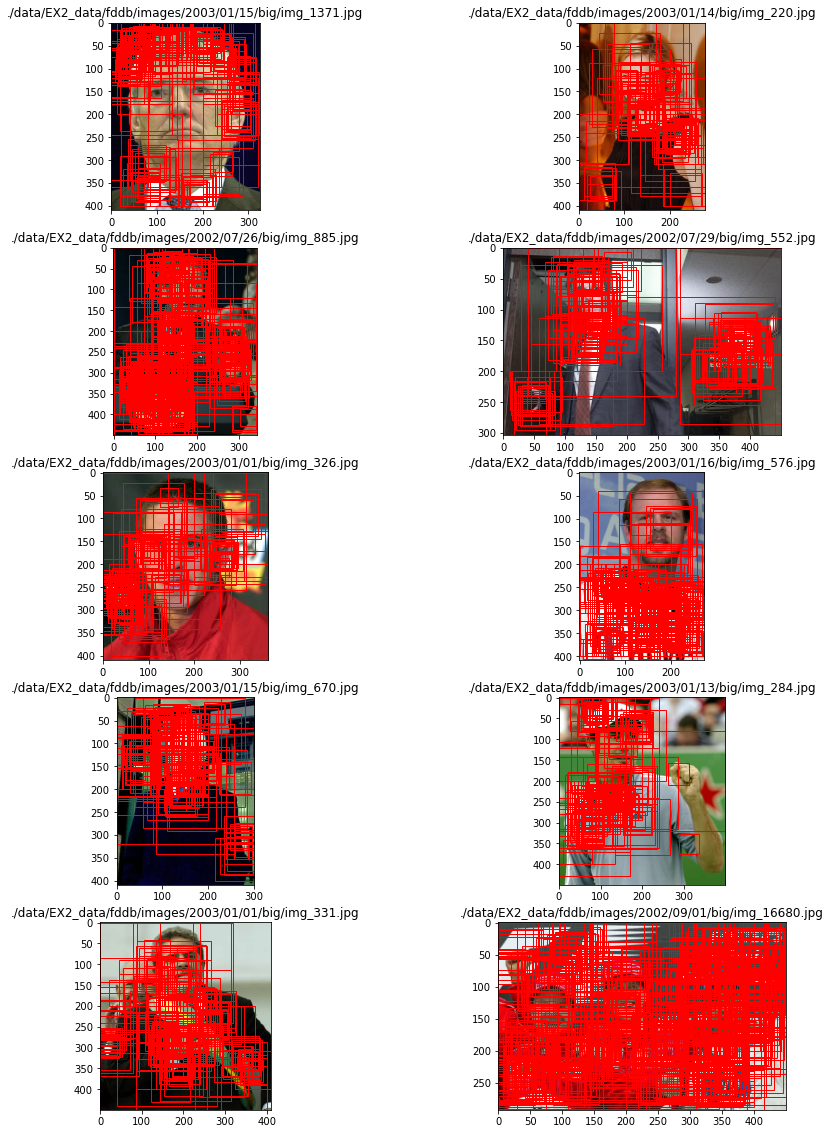

In [6]:
plt.figure(figsize = (15, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    path = utils.get_random_fddb_img()
    r= detector_model(path = path, iou_threshold = t, scales = scales)
    x = Image.open(path)
    utils.plot_with_rec(x, r, limit = 0.99)
    plt.title(path)
plt.show()

## 24 Net

In [7]:
x = utils.mData24.init(detector_model, neg_mining = True)

Prepare 24Net data...
Finished


>>> Epoch 0, train: loss 0.0012 acc 1.0000, test: loss 0.0242 acc 0.9940, 
>>> Epoch 0, train: loss 0.0012 acc 1.0000, test: loss 0.0242 acc 0.9940, 
>>> model saved to ./cache/models.24Net.best_model


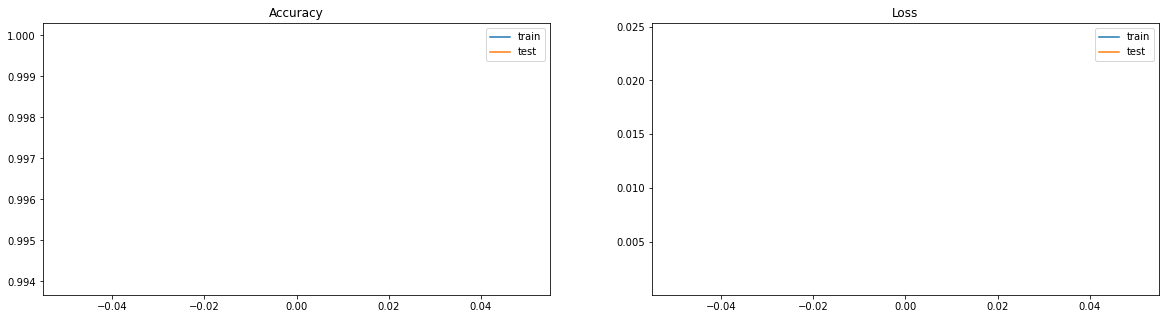

In [8]:
Net24 = nn.Sequential(
    # 3 X 24 X 24
    nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
    # 64 X 24 X 24
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 64 X 12 X 12
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
utils.train_24Net(Net24, Epochs = 1000, save = True, batch_size = 64)

## Better Detector

Generating the data for the 24 detector using negative mining (code in `utils_lib.data.mining`)

In [8]:
Net24 = torch.load("cache/models.24Net.best_model")

In [9]:
Net24= Net24.to(device)
def detector_model2(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.08, 0.13, 0.2]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    out = utils.scale_model_nms_pipeline(x, scales, Net12_FCN, iou_threshold = iou_threshold).cpu() # (N_crops, 5)
    # use 24Net to reduce FP
    with torch.no_grad():
        out_resized = utils.get_resized_crops(x, out, size = 24).to(device) # (N_crops, 3, 24, 24)
        out24 = Net24(out_resized).cpu() #(N_crops, 2)
    
    net24_threshold = 0.5
    net24_probs = out24[:, 1] # face prob
    out[:, -1] *= net24_probs
    return out
    
        

In [10]:
name =  f"detector_2"
utils.gen_fddb_out(lambda x: detector_model2(path = x, iou_threshold = t, scales = scales), ellipse = False, name = name)
cmd = f"{EX2_data_path}/fddb/evaluation/runEvaluate.pl ./fddb-test/{name}/"
print(f">>> {cmd}", end = "")
r = os.system(cmd) 
print(f", result: {r}")

>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/detector_2/, result: 0


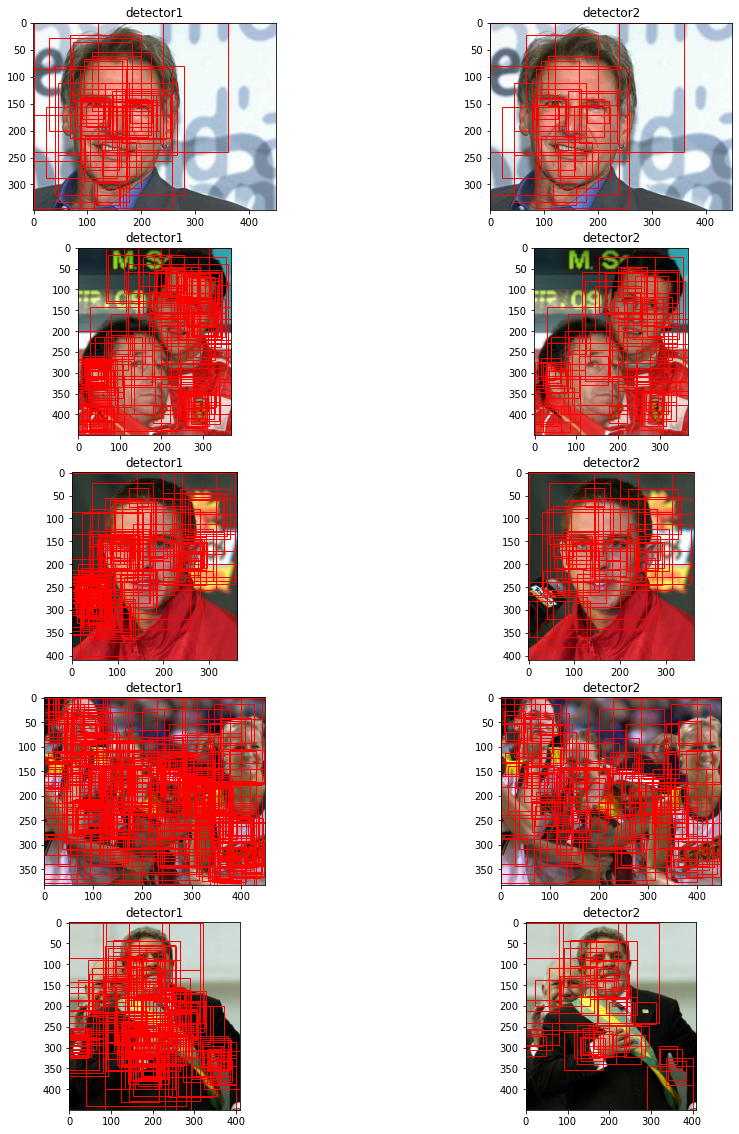

In [11]:
plt.figure(figsize = (15, 20))
for i in range(5):
    path = utils.get_random_fddb_img()
    plt.subplot(5, 2, i*2+1)
    r= detector_model(path = path, iou_threshold = t, scales = scales)
    x = Image.open(path)
    utils.plot_with_rec(x, r, limit = 0.99)
    plt.title(f"detector1")
    plt.subplot(5, 2, i*2+2)
    r= detector_model2(path = path, iou_threshold = t, scales = scales)
    x = Image.open(path)
    utils.plot_with_rec(x, r, limit = 0.99)
    plt.title(f"detector2")

plt.show()

We can see still many false positives, but less than the first detector